Core Libraries:

In [8]:
!pip install nltk==3.2.3
!pip install stanfordcorenlp==3.9.1.1
!pip install scipy

In [11]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from PIL import Image
import h5py
import json
from tqdm import tqdm
from collections import Counter, defaultdict
from random import seed, sample
import pandas as pd
from stanfordcorenlp import StanfordCoreNLP
import zipfile
from utils import sentence_normalize, un_capitalize, merge_entities, check_exact_author, list2long
sns.set(style='white', context='notebook', palette='deep')

Stanford Corenlp:

In [13]:
!wget http://nlp.stanford.edu/software/stanford-corenlp-4.5.5.zip
!unzip stanford-corenlp-4.5.5.zip

--2025-02-11 13:07:58--  http://nlp.stanford.edu/software/stanford-corenlp-4.5.5.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/software/stanford-corenlp-4.5.5.zip [following]
--2025-02-11 13:07:58--  https://nlp.stanford.edu/software/stanford-corenlp-4.5.5.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.5.5.zip [following]
--2025-02-11 13:07:58--  https://downloads.cs.stanford.edu/nlp/software/stanford-corenlp-4.5.5.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200

SemArt Dataset:

In [5]:
!wget "https://researchdata.aston.ac.uk/id/eprint/380/1/SemArt.zip"

with zipfile.ZipFile("SemArt.zip", "r") as zip_ref:
    zip_ref.extractall("SemArt")

print("Extraction complete.")

--2025-02-11 12:48:37--  https://researchdata.aston.ac.uk/id/eprint/380/1/SemArt.zip
Resolving researchdata.aston.ac.uk (researchdata.aston.ac.uk)... 52.178.142.166
Connecting to researchdata.aston.ac.uk (researchdata.aston.ac.uk)|52.178.142.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3327241783 (3.1G) [application/zip]
Saving to: ‘SemArt.zip’

SemArt.zip          100%[===================>]   3.10G  30.9MB/s    in 1m 42s  

2025-02-11 12:50:20 (31.0 MB/s) - ‘SemArt.zip’ saved [3327241783/3327241783]

Extraction complete.


In [16]:
nlp = StanfordCoreNLP('stanford-corenlp-4.5.5')
num_topics = 1

def load_annotation(path):
    ret = {}
    anno = json.load(open(path, 'r'))["annotations"]
    for item in anno:
        ret[item["img"]] = {0: item["content"]}
    return ret

def tokenize(imgs, max_len=200):
    bad_cnt = 0
    for img in tqdm(imgs):
        author = img['author']
        sent_topic_dict = img['sentences']
        token_topic_dict, template_topic_dict = defaultdict(list), defaultdict(list)
        # Sentences Processing
        for topic_key in sent_topic_dict.keys():
            sent_tuple = sent_topic_dict[topic_key]
            token_tuple, template_tuple = [], []
            topic = int(topic_key)
            for sent in sent_tuple:
                sent = sentence_normalize(sent)
                doc = nlp.ner(sent)
                tokens = [d[0] for d in doc]
                template = [d[1] + '_' if d[1] != 'O' else d[0] for d in doc]
                try:
                    tokens, template = un_capitalize(tokens, template)
                    assert len(tokens) == len(template), 'length mismatch after normalize %s' % sent
                    assert len(tokens) > 0, "no tokens in the sentence? %s" % sent
                    template = check_exact_author(tokens, template, author, verbose=False)
                    template = merge_entities(template)
                    assert len(template) > 0, "no tokens after merge entities? %s" % sent
                except Exception as e:
                    print(e)
                    bad_cnt += 1
                    print('%d-th bad sentence %s, just skip it' % (bad_cnt, sent))
                    continue
                token_tuple.append(tokens)
                template_tuple.append(template)
            long_token = list2long(token_tuple, max_len)
            long_template = list2long(template_tuple, max_len)
            token_topic_dict[topic] = long_token
            template_topic_dict[topic] = long_template
        img['sentences'] = [{'long_token': token_topic_dict, 'long_template': template_topic_dict}]
    return imgs

def read_and_resize_image(image_path, size=(256, 256)):
    img = Image.open(image_path).convert("RGB")
    img = img.resize(size, Image.LANCZOS)
    img = np.array(img, dtype=np.uint8)
    img = img.transpose(2, 0, 1)
    return img

In [21]:
def create_dataset(image_folder, output_folder, max_len=100, min_len=5, min_word_freq=20):
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    sents_train = load_annotation('annotations/semart_topic_annotated_train.json')
    sents_test = load_annotation('annotations/semart_topic_annotated_test.json')
    df_train = pd.read_csv('/content/SemArt/SemArt/semart_train.csv',delimiter='\t', encoding='Cp1252')
    df_val = pd.read_csv('/content/SemArt/SemArt/semart_val.csv',delimiter='\t', encoding='Cp1252')
    df_test = pd.read_csv('/content/SemArt/SemArt/semart_test.csv',delimiter='\t', encoding='Cp1252')

    img_names = list(df_train['IMAGE_FILE']) + list(df_val['IMAGE_FILE']) + list(df_test['IMAGE_FILE'])
    titles = list(df_train['TITLE']) + list(df_val['TITLE']) + list(df_test['TITLE'])
    types = list(df_train['TYPE']) + list(df_val['TYPE']) + list(df_test['TYPE'])
    schools = list(df_train['SCHOOL']) + list(df_val['SCHOOL']) + list(df_test['SCHOOL'])
    times = list(df_train['TIMEFRAME']) + list(df_val['TIMEFRAME']) + list(df_test['TIMEFRAME'])
    authors = list(df_train['AUTHOR']) + list(df_val['AUTHOR']) + list(df_test['AUTHOR'])

    imgs = []
    for i in tqdm(range(len(img_names))):
        jimg = {}
        jimg['id'] = img_names[i].strip().split('.')[0]
        jimg['filename'] = img_names[i]
        jimg['type'] = types[i]
        jimg['school'] = schools[i]
        jimg['timeframe'] = times[i]
        jimg['author'] = authors[i]
        jimg['title'] = titles[i]
        if img_names[i] in sents_train.keys():
            jimg['sentences'] = sents_train[img_names[i]]
            jimg['split'] = 'train'
        elif img_names[i] in sents_test.keys():
            jimg['sentences'] = sents_test[img_names[i]]
            jimg['split'] = 'test'
        else:
            continue
        imgs.append(jimg)

    imgs = tokenize(imgs, max_len=max_len)
    train_image_paths = []
    train_image_captions = []
    test_image_paths = []
    test_image_captions = []
    word_freq = Counter()
    for img in imgs:
        captions = [[] for _ in range(num_topics)]
        for c in img['sentences']:
            for topic in c['long_template'].keys():
                word_freq.update(c['long_template'][topic])
                if min_len < len(c['long_template'][topic]) <= max_len:
                    captions[int(topic)].append(c['long_template'][topic])
        if len(captions[0]) == 0:
            continue
        path = os.path.join(image_folder, img['filename'])
        if img['split'] in {'train'}:
            train_image_paths.append(path)
            train_image_captions.append(captions)
        elif img['split'] in {'test'}:
            test_image_paths.append(path)
            test_image_captions.append(captions)
    # Sanity check
    assert len(train_image_paths) == len(train_image_captions)
    assert len(test_image_paths) == len(test_image_captions)
    # Create word map
    words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
    word_map = {k: v + 1 for v, k in enumerate(words)}
    word_map['<unk>'] = len(word_map) + 1
    word_map['<start>'] = len(word_map) + 1
    word_map['<end>'] = len(word_map) + 1
    word_map['<pad>'] = 0
    if '<.>' in word_map.keys():
        print('Word map include stop dot <.>')
    base_filename = 'SemArt_{}_min_word_freq_{}_max_len'.format(min_word_freq, max_len)
    with open(os.path.join(output_folder, 'WORDMAP_' + base_filename + '.json'), 'w') as j:
        json.dump(word_map, j)
    seed(123)
    for impaths, imcaps, split in [(train_image_paths, train_image_captions, 'TRAIN'),
                                   (test_image_paths, test_image_captions, 'TEST')]:
        if len(impaths) == 0:
            continue
        with h5py.File(os.path.join(output_folder, split + '_IMAGES_' + base_filename + '.hdf5'), 'a') as h:
            h.attrs['captions_per_image'] = 1
            images = h.create_dataset('images', (len(impaths), 3, 256, 256), dtype='uint8')
            print("\nReading %s images and captions, storing to file...\n" % split)
            enc_captions = [[] for _ in range(num_topics)]
            caplens = [[] for _ in range(num_topics)]
            for i, path in enumerate(tqdm(impaths)):
                # Sample captions
                assert len(imcaps[i]) == num_topics
                captions = imcaps[i]
                captions_has_content = [x[0] for x in captions if len(x) != 0]
                for t in range(1):
                    if len(captions[t]) == 0:
                        captions[t] = sample(captions_has_content, k=1)
                # Sanity check
                assert len(captions[0]) > 0
                # Read images
                img = read_and_resize_image(impaths[i])
                assert img.shape == (3, 256, 256)
                assert np.max(img) <= 255
                images[i] = img
                for t in range(num_topics):
                    for j, c in enumerate(captions[t]):
                        # Encode captions
                        enc_c = [word_map['<start>']] + \
                                [word_map.get(word, word_map['<unk>']) for word in c] + \
                                [word_map['<end>']] + \
                                [word_map['<pad>']] * (max_len - len(c))
                        c_len = len(c) + 2
                        enc_captions[t].append(enc_c)
                        caplens[t].append(c_len)
            # Sanity check
            assert images.shape[0] * 1 == len(enc_captions[0]) == len(caplens[0])
            print('Total training image: ', images.shape[0])
            # Save encoded captions and their lengths to JSON files
            with open(os.path.join(output_folder, split + '_CAPTIONS_' + base_filename + '.json'), 'w') as j:
                json.dump(enc_captions, j)
            with open(os.path.join(output_folder, split + '_CAPLENS_' + base_filename + '.json'), 'w') as j:
                json.dump(caplens, j)

In [22]:
create_dataset(image_folder='/content/SemArt/SemArt/Images',
                output_folder='dataset_semart',
                max_len=120,
                min_len=10,
                min_word_freq=5)
nlp.close()

 12%|█▏        | 2059/17249 [06:12<26:32,  9.54it/s]

list index out of range
1-th bad sentence , just skip it


 34%|███▍      | 5870/17249 [15:25<48:20,  3.92it/s]

list index out of range
2-th bad sentence , just skip it


 36%|███▌      | 6145/17249 [16:06<23:34,  7.85it/s]

list index out of range
3-th bad sentence , just skip it


 47%|████▋     | 8182/17249 [23:55<45:09,  3.35it/s]

list index out of range
4-th bad sentence , just skip it


 66%|██████▌   | 11402/17249 [37:42<09:40, 10.08it/s]

list index out of range
5-th bad sentence  , just skip it


100%|██████████| 17249/17249 [53:09<00:00,  5.41it/s]


Word map include stop dot <.>

Reading TRAIN images and captions, storing to file...



100%|██████████| 11472/11472 [06:48<00:00, 28.11it/s]


Total training image:  11472

Reading TEST images and captions, storing to file...



100%|██████████| 724/724 [00:24<00:00, 29.31it/s]


Total training image:  724


In [49]:
# Load word map
wordmap_path = "/content/dataset_semart/WORDMAP_SemArt_5_min_word_freq_120_max_len.json"
with open(wordmap_path, 'r') as j:
    word_map = json.load(j)

vocab_size = len(word_map)  # Vocabulary size
print(f"Vocabulary size: {vocab_size}")
print("Sample Word-to-Index Mappings:")
print(list(word_map.items())[:10])  # Get the first 10 words

Vocabulary size: 6984
Sample Word-to-Index Mappings:
[('the', 1), ('PERSON_', 2), ('or', 3), ('is', 4), ('last', 5), ('most', 6), ('famous', 7), ('and', 8), ('effective', 9), ('of', 10)]


In [50]:
# Reverse the word map: index -> word
idx_to_word = {idx: word for word, idx in word_map.items()}

# Print some sample index-to-word mappings
sample_indices = list(idx_to_word.items())[:10]  # Get the first 10 indices
print("Sample Index-to-Word Mappings:")
for idx, word in sample_indices:
    print(f"  {idx}: {word}")

Sample Index-to-Word Mappings:
  1: the
  2: PERSON_
  3: or
  4: is
  5: last
  6: most
  7: famous
  8: and
  9: effective
  10: of


In [25]:
# Load images
hdf5_path = "/content/dataset_semart/TRAIN_IMAGES_SemArt_5_min_word_freq_120_max_len.hdf5"
h5_file = h5py.File(hdf5_path, 'r')

# Read image data
images = torch.tensor(h5_file['images'][:])  # Convert to Tensor
h5_file.close()

print(f"Loaded {images.shape[0]} images from {hdf5_path}")

Loaded 11472 images from /content/dataset_semart/TRAIN_IMAGES_SemArt_5_min_word_freq_120_max_len.hdf5


In [63]:
# Load caption
captions_path = "/content/dataset_semart/TRAIN_CAPTIONS_SemArt_5_min_word_freq_120_max_len.json"
caption_lengths_path = "/content/dataset_semart/TRAIN_CAPLENS_SemArt_5_min_word_freq_120_max_len.json"

with open(captions_path, 'r') as j:
    captions = json.load(j)
with open(caption_lengths_path, 'r') as j:
    caplens = json.load(j)

captions_list = captions[0]

# Print the first 5 captions
print("Total captions inside:", len(captions_list))
for i in range(min(5, len(captions_list))):
    print(f"Caption {i+1}: {captions_list[i]}")

Total captions inside: 11472
Caption 1: [6982, 1, 2, 3, 2, 4, 1, 5, 6, 7, 8, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 10, 21, 22, 6981, 23, 24, 25, 26, 27, 8, 28, 29, 30, 31, 1, 6981, 6981, 18, 32, 6981, 33, 24, 34, 6981, 2, 24, 1, 35, 18, 36, 37, 4, 38, 31, 1, 2, 39, 40, 41, 1, 42, 4, 43, 29, 1, 44, 45, 29, 1, 6981, 31, 46, 6981, 8, 6981, 2, 47, 48, 6981, 6981, 1, 49, 50, 51, 52, 53, 54, 55, 56, 6981, 18, 57, 58, 40, 6983, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Caption 2: [6982, 1, 59, 60, 61, 62, 63, 64, 65, 31, 1, 6981, 66, 67, 68, 6981, 24, 1, 69, 70, 6981, 71, 1, 6981, 72, 10, 1, 73, 74, 55, 1, 67, 4, 75, 10, 1, 6981, 2, 8, 2, 66, 76, 64, 3, 77, 78, 1, 79, 10, 80, 35, 81, 40, 11, 82, 83, 84, 85, 6981, 35, 6981, 86, 31, 87, 10, 1, 35, 88, 8, 1, 89, 6981, 90, 8, 91, 68, 92, 63, 93, 94, 95, 96, 1, 97, 98, 40, 18, 83, 99, 100, 101, 102, 103, 24, 104, 8, 105, 106, 61, 107, 108, 18, 109, 6981, 67, 40, 6983, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [35]:
class CaptionDatasetPara(Dataset):
    def __init__(self, data_folder, data_name, split, transform=None):
        self.split = split
        assert self.split in {'TRAIN', 'TRAINVAL', 'VAL', 'TEST'}
        # Open hdf5 file where images are stored
        self.h = h5py.File(os.path.join(data_folder, self.split + '_IMAGES_' + data_name + '.hdf5'), 'r')
        self.imgs = self.h['images']
        # Captions per image
        self.cpi = self.h.attrs['captions_per_image']
        # Load encoded captions (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPTIONS_' + data_name + '.json'), 'r') as j:
            self.captions = json.load(j)
        # Load caption lengths (completely into memory)
        with open(os.path.join(data_folder, self.split + '_CAPLENS_' + data_name + '.json'), 'r') as j:
            self.caplens = json.load(j)
        # PyTorch transformation pipeline for the image (normalizing, etc.)
        self.transform = transform
        # Total number of datapoints
        self.dataset_size = len(self.imgs)
    def __getitem__(self, i):
        img = torch.FloatTensor(self.imgs[i // self.cpi] / 255.)
        if self.transform is not None:
            img = self.transform(img)
        caption = torch.stack([torch.LongTensor(self.captions[0][i])], dim=0)
        caplen = torch.stack([torch.LongTensor([self.caplens[0][i]]),], dim=0)
        return img, caption, caplen
    def __len__(self):
        return self.dataset_size

In [36]:
data_folder = "dataset_semart"
data_name = "SemArt_5_min_word_freq_120_max_len"
batch_size = 32
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# Create dataloaders
train_loader = torch.utils.data.DataLoader(
    CaptionDatasetPara(data_folder, data_name, 'TRAIN', transform=transforms.Compose([normalize])),
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    CaptionDatasetPara(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True)

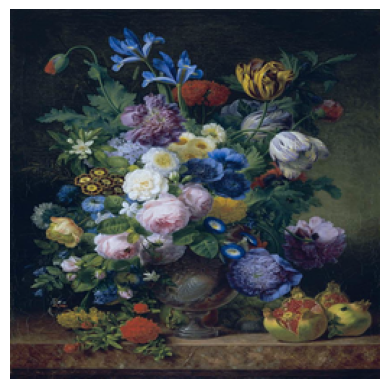

Encoded Description: [6982, 83, 1235, 334, 2572, 2575, 2573, 5587, 5588, 8, 59, 56, 917, 18, 32, 1248, 244, 476, 24, 2077, 1250, 8, 5713, 55, 32, 188, 1230, 40, 136, 4, 227, 8, 1348, 406, 150, 6981, 1304, 32, 116, 40, 6983, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Description: <start> this stilllife depicts tulips carnations roses irises narcissi and various other flowers in a silver vase together with figs grapes and pomegranates on a marble ledge <.> it is signed and dated lower right <unk> F a CITY_ <.> <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [61]:
# Preview the first image in the train loader
data_iter = iter(train_loader)
img, caption, caplen = next(data_iter)
sample_img = img[0].permute(1, 2, 0).numpy()
# Normalize for display
sample_img = (sample_img - sample_img.min()) / (sample_img.max() - sample_img.min())

# Display the image
plt.imshow(sample_img)
plt.axis("off")
plt.show()

caption_indices = caption[0].squeeze().tolist()
decoded_caption = [idx_to_word[idx] for idx in caption_indices if idx in idx_to_word]
# Print results
print("Encoded Description:", caption_indices)
print("Decoded Description:", " ".join(decoded_caption))
print("Description Length:", caplen[0].item())